<a href="https://colab.research.google.com/github/vitaliy-sharandin/data_science_projects/blob/master/portfolio/eda/AI_risks_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI risks EDA
This project provides analysis of AI related incidents throughout the years.

# Datasets
The dataset used in project is based on the website aggregating AI incidents:
https://incidentdatabase.ai/


* AI Incident Database <br>
https://www.kaggle.com/datasets/konradb/ai-incident-database


In [1]:
!pip install -U -q datasets
!pip install -U -q ydata-profiling
!pip install -U -q keybert
!pip install -U -q keyphrase-vectorizers
!pip install -U -q spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [2]:
from datasets import load_dataset
import typing_extensions
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseTfidfVectorizer
from sentence_transformers import SentenceTransformer, util
import spacy
import typing_extensions

In [3]:
incident_dataset = load_dataset("vitaliy-sharandin/ai-incidents")
incident_dataset = incident_dataset['train'].to_pandas()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/514 [00:00<?, ? examples/s]

In [4]:
profile = ProfileReport(incident_dataset, title="Fraud data report", dark_mode=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Distribution of incidents over time

## Amount of incidents through time

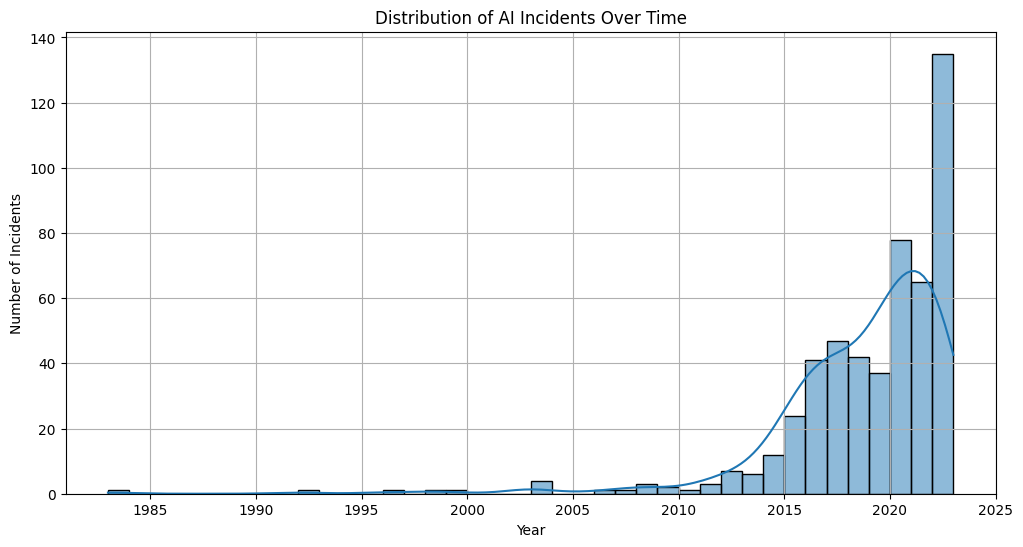

In [5]:
incident_dataset['date'] = pd.to_datetime(incident_dataset['date'])
incident_dataset['year'] = incident_dataset['date'].dt.year
plt.figure(figsize=(12, 6))
sns.histplot(incident_dataset['year'], bins=40, kde=True)
plt.title('Distribution of AI Incidents Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()

**Insights**
* Early Years <br>
There are very few incidents reported before the year 2010 which can be related to the fact that deep learning models boom happened in early 2010s.

* Rapid Increase <br>
There is a noticeable increase in the number of incidents starting from around 2015. This correlates with wider adoption of models as well as development of advanced programs such as AlphaGo and introduction of transformer arhitecture in 2017.

In [6]:
earliest_incident_year = incident_dataset['year'].min()
incident_dataset[incident_dataset['year']==earliest_incident_year]

_id  incident_id       date  \
28  ObjectId(625763df343edc875fe63a19)           27 1983-09-26   

                                              reports  \
28  [342,343,344,345,346,347,349,350,351,352,353,3...   

   Alleged deployer of AI system Alleged developer of AI system  \
28              ["soviet-union"]               ["soviet-union"]   

   Alleged harmed or nearly harmed parties  \
28                   ["all-life-on-earth"]   

                                          description                title  \
28  An alert of five incoming intercontinental bal...  Nuclear False Alarm   

    year spacy_negative_outcomes keybert_negative_outcomes  \
28  1983                An alert                     alert   

                 Cluster  
28  bias, content, false

Earliest incident happended in 1983 when Stanislav Petrov identified incoming intercontinental ballistic missiles shown by the automatic aerial strike warning system flying at Soviet Union as false positive, preventing nuclear armageddon.

# Deployers and developers of models

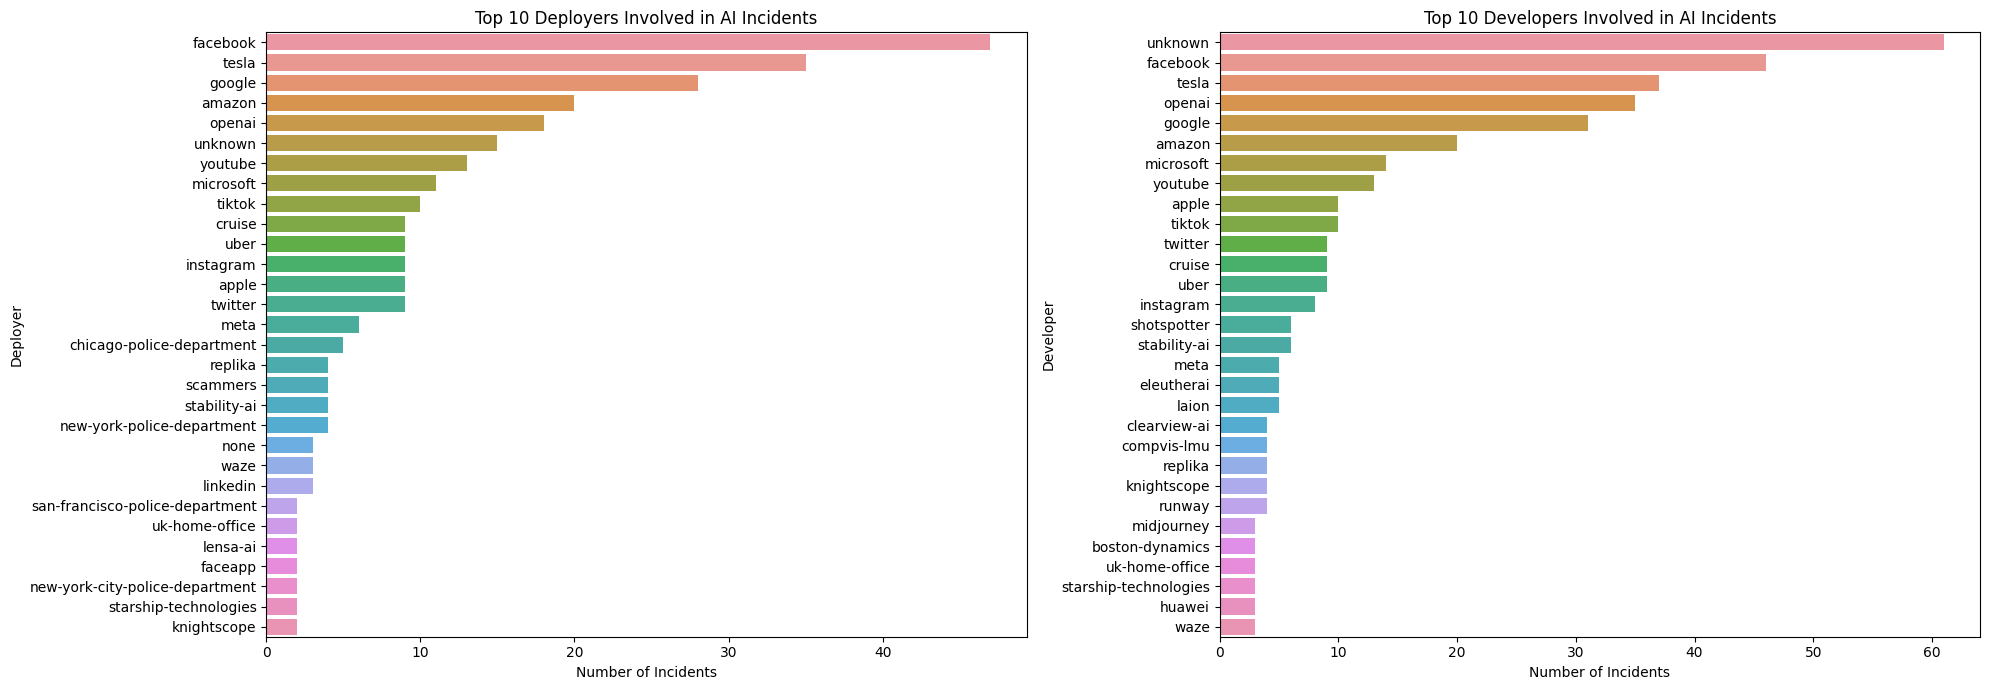

In [7]:
def count_occurrences(column):
    items = column.str.replace('[\[\]"]', '', regex=True).str.split(',')
    counter = Counter([item.strip() for sublist in items.dropna() for item in sublist])
    return counter

deployer_counts = count_occurrences(incident_dataset['Alleged deployer of AI system'])
developer_counts = count_occurrences(incident_dataset['Alleged developer of AI system'])


deployer_df = pd.DataFrame(deployer_counts.items(), columns=['Deployer', 'Count']).sort_values('Count', ascending=False).head(30)
developer_df = pd.DataFrame(developer_counts.items(), columns=['Developer', 'Count']).sort_values('Count', ascending=False).head(30)


fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(x='Count', y='Deployer', data=deployer_df, ax=axes[0])
axes[0].set_title('Top 10 Deployers Involved in AI Incidents')
axes[0].set_xlabel('Number of Incidents')

sns.barplot(x='Count', y='Developer', data=developer_df, ax=axes[1])
axes[1].set_title('Top 10 Developers Involved in AI Incidents')
axes[1].set_xlabel('Number of Incidents')

plt.tight_layout()
plt.show()

**Insights**

  * "Facebook" appears to be both the most frequent deployer involved in AI incidents, followed by "Tesla" and "Google", as platforms with large user bases and extensive AI deployments are more prone to incidents, especially Facebook which knowingly feeds their machine learning models with user data.

  * "Facebook", "Tesla", "OpenAI" and "Google" are among the top developers involved in AI incidents. This isn't surprising given their role as major technology companies with extensive AI research and deployment.
  
  * Noticeably, many of the top deployers and developers are tech giants, which could imply a higher level of responsibility for these organizations in ensuring AI safety and ethics.

# Harmed parties

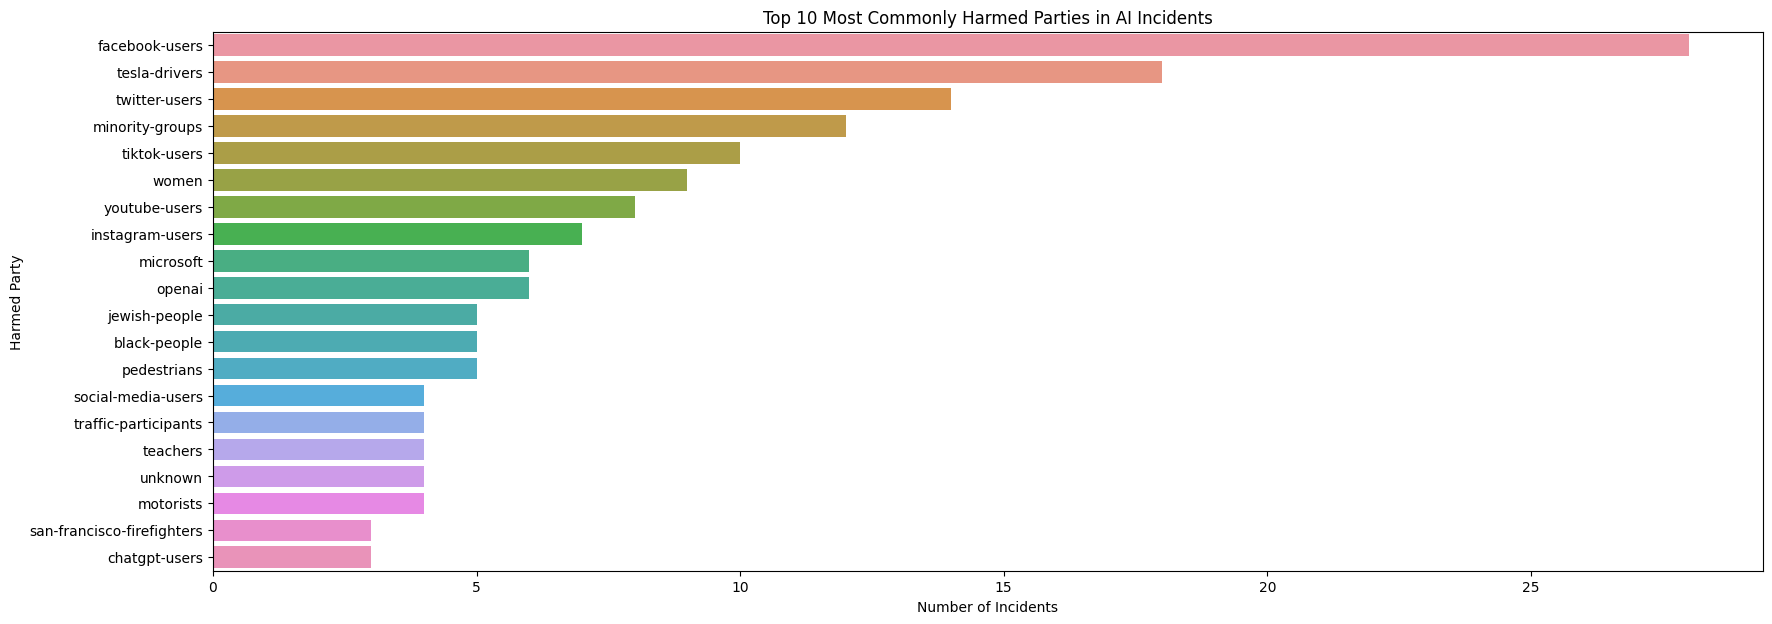

In [8]:
harmed_counts = count_occurrences(incident_dataset['Alleged harmed or nearly harmed parties'])

harmed_df = pd.DataFrame(harmed_counts.items(), columns=['Harmed Party', 'Count']).sort_values('Count', ascending=False).head(20)

plt.figure(figsize=(20, 7))
sns.barplot(x='Count', y='Harmed Party', data=harmed_df)
plt.title('Top 10 Most Commonly Harmed Parties in AI Incidents')
plt.xlabel('Number of Incidents')

plt.show()

**Insights**


  * The category "facebook-users" tops the list which correlates with what we saw previously in deployers and developers analysis, meaning Facebook is harming its own users. Also, we can see that other big platform users are often harmed by their owners.

  * We can see that minority groups in general, racial groups such as Jewish and Black as well as women are affected by biases of AI.

  * Categories like "pedestrians", "tesla-drivers" and "motorists" are contributing to incidents in automotive industry.

# AI incident types

## Incident keywords extraction

Below you can see the keywords extraction from either title or description of incident indicating what was the most probable reason of incident in one phrase or word.<br>
Here `KeyBert` together with `KeyphraseTfidfVectorizer` were used for finding max similarity to the words in the filtering list containning different generalized incident phrases. Manual verification of result was used for calibration of this method which in the end performs pretty well.

In [9]:
import traceback

nlp = spacy.load('en_core_web_lg')

kw_model = KeyBERT()
kph_vectorizer = KeyphraseTfidfVectorizer(spacy_pipeline=nlp, pos_pattern = '<J.*>*<V.*>*<N.*>*')

st_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# keyword filter
failures_filter = ["wrong action","negative cause","failure reason","AI failure","software failure",
                  "bad", "fail", "crash", "stop", "halt", "break", "malfunction", "kill", "die",
                  "hurt","bias","disrespect","discrimination","racism","sexism","wrong","error"]

def keybert_failures_combined(row, similarity_threshold=0.6, filter_phrases=failures_filter):

  def get_most_relevant(text):
      keywords_tuples = kw_model.extract_keywords(text, vectorizer=kph_vectorizer)
      keywords = [kw[0] for kw in keywords_tuples if kw]

      keyword_embeddings = st_model.encode(keywords, convert_to_tensor=True)
      filter_phrase_embeddings = st_model.encode(filter_phrases, convert_to_tensor=True)

      max_similarities = [max([util.pytorch_cos_sim(keyword_embedding, filter_phrase_embedding).item()
                                for filter_phrase_embedding in filter_phrase_embeddings])
                          for keyword_embedding in keyword_embeddings]

      if not max_similarities:
          return None, 0

      most_relevant_keyword = keywords[max_similarities.index(max(max_similarities))]
      return most_relevant_keyword, max(max_similarities)

  desc_keyword, desc_similarity = get_most_relevant(row['description'])
  title_keyword, title_similarity = get_most_relevant(row['title'])

  return desc_keyword if desc_similarity >= title_similarity else title_keyword

incident_dataset['ai_failures_summary'] = incident_dataset.apply(keybert_failures_combined, axis=1)

incident_dataset[['description','title','ai_failures_summary']]

2023-10-13 21:26:16,256 - KeyphraseVectorizer - INFO - It looks like you do not have downloaded a list of stopwords yet. It is attempted to download the stopwords now.
INFO:KeyphraseVectorizer:It looks like you do not have downloaded a list of stopwords yet. It is attempted to download the stopwords now.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


description  \
0    A self-driving public shuttle by Keolis North ...   
1    An Uber autonomous vehicle (AV) in autonomous ...   
2    YouTube’s content filtering and recommendation...   
3    Google Image returns results that under-repres...   
4    Researchers from Boston University and Microso...   
..                                                 ...   
509  Amazon Fresh's system of tracking cameras in i...   
510  Images which were collected in an R&D project ...   
511  Facebook's political ad delivery system report...   
512  A Guardian journalist was able to verify their...   
513  Telegram channel Torswats offered paid service...   

                                                 title ai_failures_summary  
0      Las Vegas Self-Driving Bus Involved in Accident           collision  
1                 Uber AV Killed Pedestrian in Arizona   killed pedestrian  
2    Google’s YouTube Kids App Presents Inappropria...          disturbing  
3                 Gender Biases of Google Image Search       gender biases  
4                   Common Biases of Vector Embeddings       common biases  
..                                                 ...                 ...  
509  Amazon Fresh Cameras Failed to Register Purcha...              failed  
510  Images Captured by iRobot's Roomba Containing ...              irobot  
511  Facebook Political Ad Delivery Algorithms Infe...          inhibiting  
512  Australian Journalist Able to Access Centrelin...           own voice  
513  AI Voices Abused by Telegram User to Make Swat...              abused  

[514 rows x 3 columns]

## Incidents cloud

Now we create a cloud of words to see the most frequent out of those incident reasons we have found in previous step as a quick and simple glimpse onto main types of incidents.

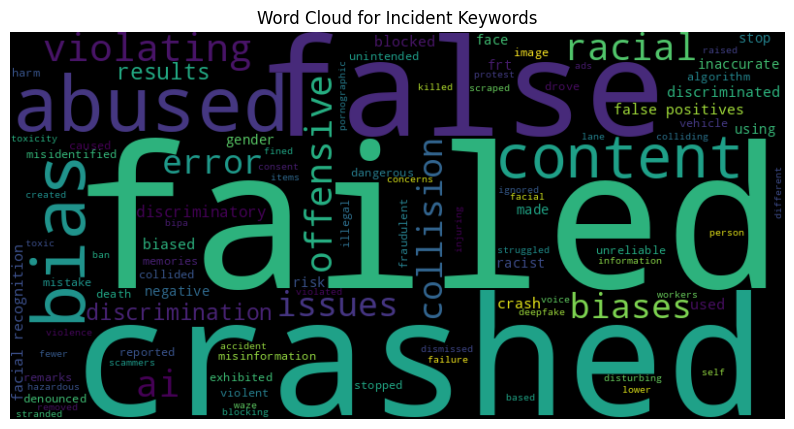

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color='black',
    max_words=100,
    width=800,
    height=400
).generate(' '.join(incident_dataset['ai_failures_summary']))

# Plotting the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Incident Keywords')
plt.show()

## Cluster analysis
Now let's form groups out of incident reasons with cluster analysis to see main reasons of incidents.

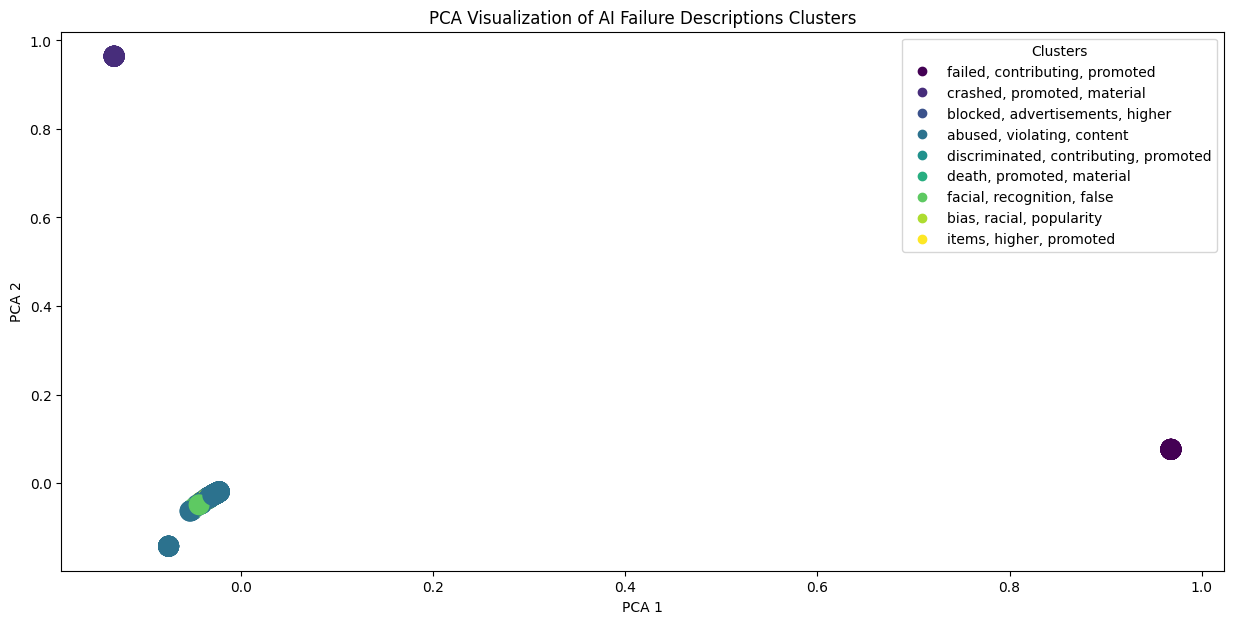

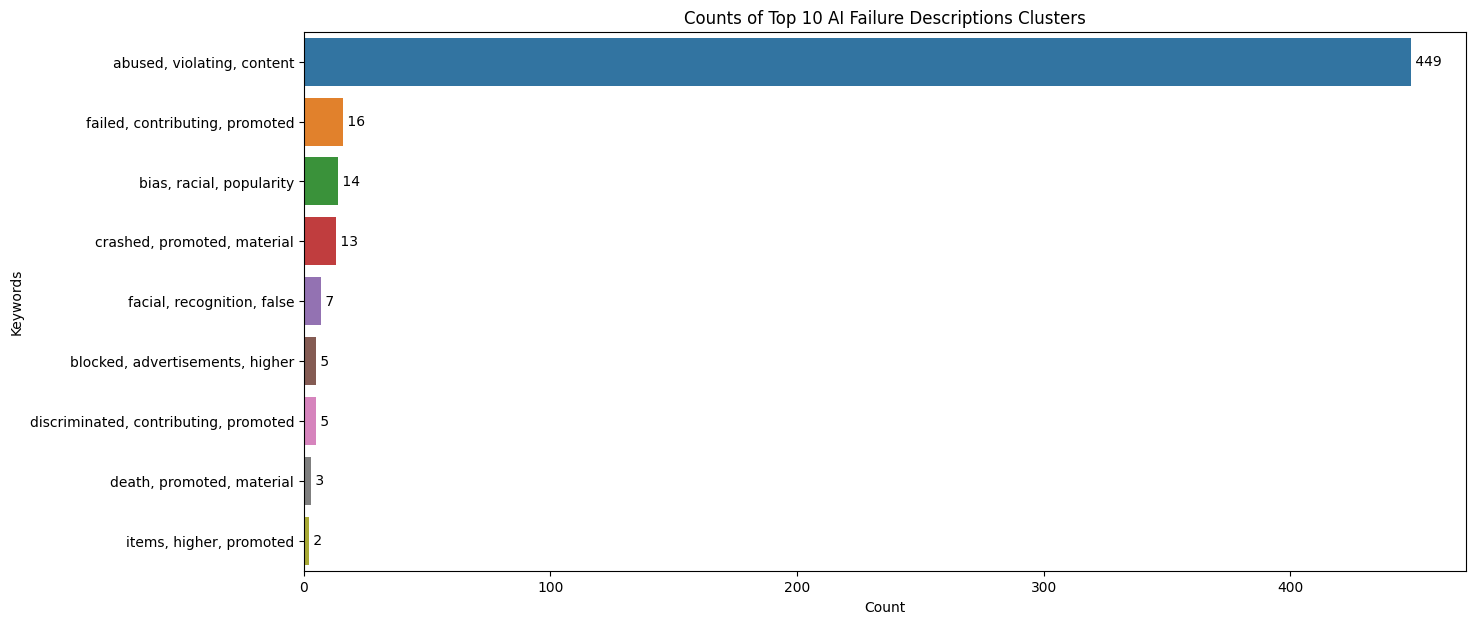

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def get_top_terms_for_cluster(data, clusters, labels, n=3):
    """
    Returns a dictionary of cluster centers (mean TF-IDF vector of each cluster) and their top n keywords.
    It aims to capture the most distinguishing features of each cluster.
    """
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    overall_mean = df.mean(axis=0)

    top_keywords = {}

    for i, r in df.iterrows():
        relative_difference = r - overall_mean
        top_indices = np.argsort(relative_difference)[-n:][::-1]
        top_keywords[i] = [labels[j] for j in top_indices]

    return top_keywords

def tokenize_and_filter(sentence):
  tokens = nlp(sentence)
  return [token.text for token in tokens if token.pos_ in ["NOUN", "ADJ", "ADV", "VERB"]]

def cluster_and_visualize(df, column="description", n_clusters=9):
    # Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=10000, tokenizer=tokenize_and_filter)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])

    # KMeans Clustering
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = km.fit_predict(tfidf_matrix)

    # Determine Cluster Names
    cluster_keywords = get_top_terms_for_cluster(tfidf_matrix, clusters, tfidf_vectorizer.get_feature_names_out(), n=3)
    df['Keyword'] = [', '.join(cluster_keywords[cluster]) for cluster in clusters]
    df['ClusterIndex'] = clusters

    # Visualization - PCA plot
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())

    plt.figure(figsize=(15, 7))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=200)
    plt.title('PCA Visualization of AI Failure Types Clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    legend_labels = [', '.join(cluster_keywords[i]) for i in range(n_clusters)]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters")
    plt.show()

    # Visualization - Cluster Count plot
    top_clusters = df['Keyword'].value_counts().head(10).reset_index()
    top_clusters.columns = ['Keyword', 'Count']

    plt.figure(figsize=(15, 7))
    sns_barplot = sns.barplot(x='Count', y='Keyword', data=top_clusters)
    plt.title('Counts of Top 10 AI Failure Descriptions Clusters')
    plt.xlabel("Count")
    plt.ylabel("Keywords")

    # Display counts on the bars
    for index, value in enumerate(top_clusters['Count']):
        sns_barplot.text(value, index, f' {value}', color='black', ha="left", va="center")

    plt.show()

    return df

incident_dataset = cluster_and_visualize(incident_dataset, column='ai_failures_summary')

**Insights**

As a result we obtained 9 clusters, each described by 3 most hot words in the given cluster.

Let's analyze each cluster:

1. "abused, violating, content": This cluster likely pertains to instances where AI systems encountered content that was abusive or violated certain guidelines. It's suggestive of concerns related to content moderation and the challenges AI might face in distinguishing appropriate content from inappropriate ones.

2. "failed, contributing, promoted": This suggests situations where AI might have failed in tasks where it was expected to contribute effectively, perhaps in promoting certain content or data. It could indicate inefficiencies or incorrect behaviors in promotion algorithms.

3. "bias, racial, popularity": This points towards issues of racial bias in AI systems. The AI might be favoring or discriminating against content based on racial implications, potentially leading to skewed popularity results or perceptions.

4. "crashed, promoted, material": This cluster could refer to system malfunctions or crashes related to promoting specific materials or content. Perhaps certain inputs or materials led the AI to become unstable.

5. "facial, recognition, false": Clear indications of issues with facial recognition technology. This might pertain to false positives or negatives where the AI incorrectly identifies or fails to recognize a face.

6. "blocked, advertisements, higher": This suggests scenarios where the AI might have blocked advertisements or content that perhaps should have been given higher priority or visibility. It could indicate overzealous filtering or misinterpretation of ad content.

7. "discriminated, contributing, promoted": Here, AI seems to have shown discriminatory behavior in how it contributes to promoting certain content or data. Discrimination could be based on various factors, not necessarily racial.

8. "death, promoted, material": A potentially serious cluster, this might indicate situations where content or material related to death was incorrectly promoted by the AI, leading to inappropriate or sensitive displays.

9. "items, higher, promoted": This suggests that there might have been items that the AI should have prioritized or promoted more but didn't. It could point to inefficiencies in content ranking or recommendation systems.



# Clusters frequency through time



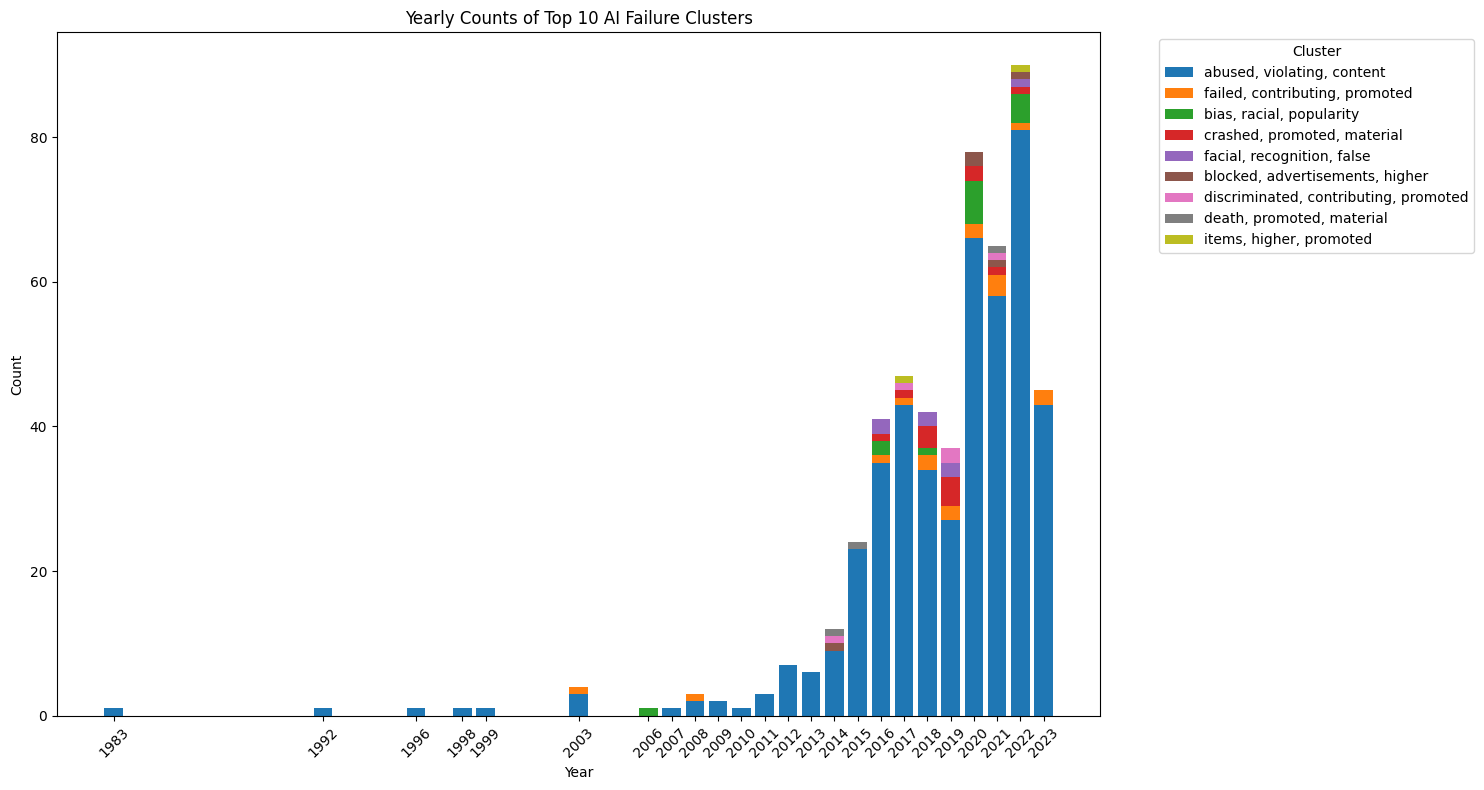

In [35]:
def visualize_clusters_stacked_bar_yearly(df, date_column="date"):
    # Extract year from 'date' column
    df['Year'] = pd.to_datetime(df[date_column]).dt.year

    # Extract top 10 clusters
    top_clusters = df['Keyword'].value_counts().head(10).index.tolist()

    # Filter dataframe to only include top 10 clusters
    top_clusters_df = df[df['Keyword'].isin(top_clusters)]

    # Pivot the data to get years as rows and clusters as columns
    pivot_table = top_clusters_df.groupby(['Year', 'Keyword']).size().unstack().fillna(0)

    # Sort columns based on their total count across all years
    sorted_columns = pivot_table.sum().sort_values(ascending=False).index
    pivot_table = pivot_table[sorted_columns]

    # Plotting
    plt.figure(figsize=(15, 8))
    bottom = np.zeros(len(pivot_table))

    for cluster in sorted_columns:
        plt.bar(pivot_table.index, pivot_table[cluster], bottom=bottom, label=cluster)
        bottom += pivot_table[cluster].values

    plt.title('Yearly Counts of Top 10 AI Failure Clusters')
    plt.ylabel('Count')
    plt.xlabel('Year')
    plt.xticks(pivot_table.index, rotation=45)  # Ensure each year is displayed
    plt.gca().yaxis.grid(False)    # Remove the y-axis grid
    plt.gca().xaxis.grid(False)    # Remove the x-axis grid
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_clusters_stacked_bar_yearly(incident_dataset)

1. Initial Observations (1988 - 2003):<br>
During the early years, there's a noticeable presence of "abused, violating, content" reports. The counts are minimal, but this shows that even in the early days of AI and computational technology, there were concerns about content violations.
The AI failures appear relatively stable and low during this period, suggesting that AI use was either limited or the systems in place were rudimentary.

2. Emergence of Multiple Concerns (2004 - 2011):<br>
This period sees an uptick in various AI failure clusters. It's also when multiple categories of failures emerge. Notably, "bias, racial, popularity" and "crashed, promoted, material" begin to appear.
This could be indicative of a period when AI began to be utilized more widely across various industries, leading to a diversity in the types of problems encountered.

3. Sharp Rise in Failures (2012 - 2018):<br>
There's a significant increase in the reported failures, especially in "abused, violating, content." This suggests that AI might have been integrated into more user-centric platforms where content moderation became crucial, like social media or content-sharing platforms.
The rise in "failed, contributing, promoted" and "discriminated, contributing, promoted" could hint towards AI's increasing role in content promotion and recommendation systems and the pitfalls associated with it.
Interestingly, "facial, recognition, false" starts appearing around 2016, reflecting the growing use and subsequent challenges of facial recognition technology.

4. Recent Trends (2019 - 2023):<br>
The failures related to "abused, violating, content" remain predominant, emphasizing continued challenges in content moderation.
However, there is a decline in "bias, racial, popularity" after 2021, which might suggest that efforts have been made to address racial bias in AI systems.
"crashed, promoted, material" and "facial, recognition, false" also appear prominent in these years, indicating that while some issues have been addressed, others persist or have become more prevalent with the evolution of AI technologies.

# Summary
The progression over time suggests that as AI technologies have become more integrated into various sectors, the nature and number of failures have evolved. Early concerns about content violations persist today, indicating the complexities of online content moderation. Issues like racial bias emerged and grew with the rise of AI but seem to show signs of decline in recent years, possibly due to interventions. However, as newer technologies like facial recognition became prevalent, new categories of failures emerged. The overall trend underscores the need for continuous monitoring, evaluation, and improvement in AI systems as they become integral to our daily lives.